# Deep learning solution method with all-in-one expectation operator for RBC

In [1]:
import tensorflow as tf
import numpy as np
from math import sqrt, exp, log
from matplotlib import pyplot as plt
from tqdm import tqdm as tqdm         # tqdm is a nice library to visualize ongoing loops
import datetime
from mpl_toolkits.mplot3d import Axes3D 
import random as rd
import pandas as pd
# followint lines are used for indicative typing
from typing import Tuple
class Vector: pass

We want to extract our model with dolo.

In [2]:
from dolo import *
import dolo.compiler.factories as f

# The model

In this first part we write down all the model information we need in order to build the neuronne network.

In [3]:
model = yaml_import('rbc.yaml')

# No need for this at the moment, but the goal is to get the model information like this later.

We must now extract the information we need from this model structure and adapt it to our DL problem.

In [4]:
ff = f.get_factory(model, eq_type = 'auxiliary')
ff

FlatFunctionFactory(preamble={'y__0_': '((exp(z__0_))*((k__0_)^(alpha_)))*((n__0_)^(1 - (alpha_)))', 'c__0_': 'y__0_ - (i__0_)', 'rk__0_': '((alpha_)*(y__0_))/(k__0_)', 'w__0_': '((1 - (alpha_))*(y__0_))/(n__0_)'}, content={'out0__0_': 'y__0_', 'out1__0_': 'c__0_', 'out2__0_': 'rk__0_', 'out3__0_': 'w__0_'}, arguments={'m': ['e_z__0_'], 's': ['z__0_', 'k__0_'], 'x': ['n__0_', 'i__0_'], 'p': ['beta_', 'sigma_', 'eta_', 'chi_', 'delta_', 'alpha_', 'rho_', 'zbar_', 'sig_z_']}, funname='auxiliary')

I do not know yet how to take this FlatFunctionFactory and extract the information I want. For the time being, I will write everything down manually but latter I would like to make this step automatic. 

In [5]:
calibration = model.get_calibration()
print(calibration)

# Je pourrais facilement utiliser ça pour avoir tous les paramètres du modèle

{'beta': 0.99, 'phi': 1.0, 'delta': 0.025, 'alpha': 0.33, 'rho': 0.8, 'sigma': 5.0, 'eta': 1.0, 'sig_z': 0.016, 'zbar': 0.0, 'chi': 23.95785990938192, 'c_i': 1.5, 'c_y': 0.5, 'e_z': 0.0, 'n': 0.33, 'z': 0.0, 'rk': 0.03510101010101017, 'w': 2.0202695647041975, 'k': 9.354978290145986, 'y': 0.9950581438095304, 'i': 0.23387445725364966, 'c': 0.7611836865558808, 'V': -27.288057500907858, 'u': -2.0492067865980133, 'm': 3.9133855739957273, 'kss': 10.0}


In [6]:
# Model parameters

β = 0.99
σ = 5
η = 1
δ = 0.025
α = 0.33
ρ = 0.8          
σ_z = 0.016
kss = 10
n = 0.33
zbar = 0

z = zbar
rk = 1/β-1+δ
k = n/(rk/α)**(1/(1-α))
w = (1-α)*exp(z)*(k/n)**(α)
y = exp(z)*(k**α)*(n**(1-α))
i = δ*k
c = y - i
ꭓ = w/c**σ/n**η
V = log(c)/(1-β)
u = c**(1-σ)/(1-σ) - ꭓ*n**(1+η)/(1+η)
m = β/(c**σ)*(1-δ+rk)

In [7]:
# Standard deviation for ergodic distribution of state variable z
σ_e_z = σ_z/(1-ρ**2)**0.5

# bounds for state variables z and k
zmin = -2*σ_e_z
zmax = 2*σ_e_z
kmin = kss*0.5
kmax = kss*1.5

# The neural network

In this first notebook, we try to solve our problem using only one neural network.
We look for a decision rule 

$$
\begin{equation*}
\left( 
\begin{matrix}
c  \\ 
i%
\end{matrix}%
\right) =\varphi (s;\theta ),
\end{equation*}
$$

where $s=(z,k)$ is the 2-dimensional state space, and $\varphi$ is a function to be determined.

In [8]:
# construction of neural network number 1 that gives c

layers = [
    tf.keras.layers.Dense(32, activation='sigmoid', input_dim=2, bias_initializer='he_uniform'),
    tf.keras.layers.Dense(32, activation='sigmoid'),
    tf.keras.layers.Dense(32, activation='sigmoid'),
    tf.keras.layers.Dense(2, activation=tf.keras.activations.linear)
]
perceptron = tf.keras.Sequential(layers)

Next, we create the decision rule which takes as input 2 vectors of the same size $n$ for the states $z$, $k$ and returns two vectors of size $n$ for $c$ and $i$, respectively. We use an exponential non-linear transformation for both of these variables:


$$
\begin{equation*}
\varphi(s;\theta)=\left(\begin{matrix}\exp(\mathcal{N}_1(s;\theta))\\ 
\exp(\mathcal{N}_2(s;\theta))\end{matrix}\right)
\end{equation*}
$$


where $\mathcal{N}_1$ and $\mathcal{N}_2$ denote first and second component of neural network output. This transformation ensures $c>0$ and $i>0$

In [9]:
def dr(z: Vector, k: Vector)-> Tuple[Vector]:            # dr = decision rule   

    # we normalize state variable z by its 2 standard deviation
    # so that it is typically between -1 and 1 
    z_norm = z/σ_e_z/2

    # we normalize endogenous state variable k between -1 and 1
    k = (k-kmin)/(kmax-kmin)*2.0-1.0

    # we prepare input to the perceptron
    s = tf.concat([_e[:,None] for _e in [z_norm,k]], axis=1) # equivalent to np.column_stack

    x = perceptron(s) # n x 2 matrix             # The deltas are hidden in this perceptron function
    
    # We apply exp because this ensures that c and i are always positive
    c = tf.exp(x[:,0])
    c = tf.cast(c, tf.float32)
    i = tf.exp(x[:,1])
    i = tf.cast(i, tf.float32)
    
    return (c,i)

In [10]:
zvec = np.linspace(zmin, zmax, 100)
kvec = np.linspace(kmin, kmax, 100)

(cvec,ivec) = dr(zvec,kvec)
a = tf.exp(zvec)
a = tf.cast(a, tf.float32)
b = kvec**α
b = tf.cast(b, tf.float32)
nvec = ((cvec+ivec)/(a*b))**(1/(1-α))

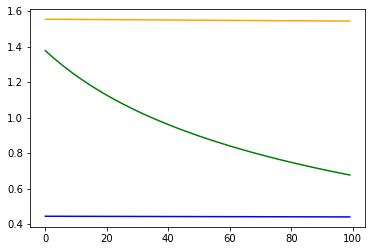

In [11]:
plt.plot(cvec,color='blue')
plt.plot(ivec,color='orange')
plt.plot(nvec,color='green')         # Just to check that there is no issue until now

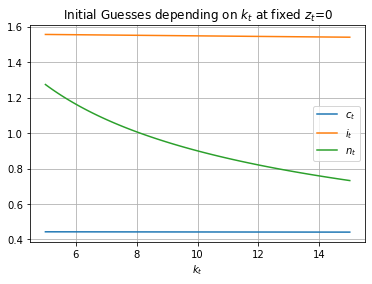

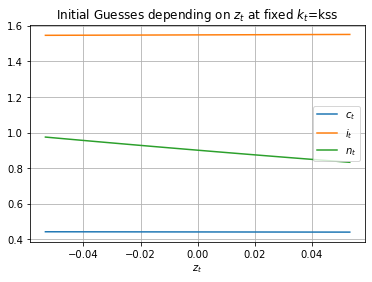

In [12]:
cmat = []
imat = []
nmat = []

for z in zvec :
    zvec_const = z*kvec/kvec
    (cvec,ivec) = dr(zvec_const,kvec)
    a = tf.exp(zvec_const)
    a = tf.cast(a, tf.float32)
    b = kvec**α
    b = tf.cast(b, tf.float32)
    nvec = ((cvec+ivec)/(a*b))**(1/(1-α))
    cmat.append(cvec.numpy())
    imat.append(ivec.numpy())
    nmat.append(nvec.numpy())

cmat = np.asarray(cmat)
imat = np.asarray(imat)
nmat = np.asarray(nmat)

plt.figure(1)
#plt.plot(kvec, kvec, linestyle='--', color='black')
plt.plot(kvec,cmat[49],label = '$c_t$')
plt.plot(kvec,imat[49],label = '$i_t$')
plt.plot(kvec,nmat[49],label = '$n_t$')
plt.xlabel("$k_t$")
plt.title("Initial Guesses depending on $k_t$ at fixed $z_t$=0")
plt.legend()
plt.grid()

l=[]
m=[]
o=[]
for a in range(len(cmat)):
    l.append(cmat[a][49])
    m.append(imat[a][49])
    o.append(nmat[a][49])

plt.figure(2)
#plt.plot(zvec, zvec, linestyle='--', color='black')
plt.plot(zvec,l,label = '$c_t$')
plt.plot(zvec,m,label = '$i_t$')
plt.plot(zvec,o,label = '$n_t$')
plt.xlabel("$z_t$")
plt.title("Initial Guesses depending on $z_t$ at fixed $k_t$=kss")
plt.legend()
plt.grid()

To find the unknown decision function for c and i, we define two residuals coming from the "arbitrage" equations. For this, we define :

$$
\begin{gather*}
h_{1}=\chi E_{\epsilon }[ \frac{n^{\eta}c^{\sigma}}{w}], \\
h_{2}=\beta E_{\epsilon }[ \frac{c}{c^{\prime}} (1 - \delta + r_{k}^{\prime}) ]
\end{gather*}
$$

where $\epsilon'=\epsilon'_z$ .

We next construct the residuals in the above two equations which we will minimize. For given vectors of current state $s=(z,k)$ we use next-period shocks $\epsilon'$ to compute realized residuals:

$$
\begin{equation*}
\begin{matrix}
R_1(s,\epsilon') = h_{1} - \chi\frac{n^{\eta}c^{\sigma}}{w}, 
\\ 
R_2(s,\epsilon') = h_{2} - \beta\frac{c}{c^{\prime}} (1 - \delta + r_{k}^{\prime})
\end{matrix}
\end{equation*}
$$

In [13]:
def Residuals(e_z: Vector, z: Vector, k: Vector):

    # all inputs are expected to have the same size n
    size = tf.size(z)

    # arguments correspond to the values of the states today
    (c,i) = dr(z, k)

    y = c + i
    a = tf.exp(z)
    a = tf.cast(a, tf.float32)
    b = k**α
    b = tf.cast(b, tf.float32)
    n = (y/(a*b))**(1/(1-α))
    n = tf.cast(n, tf.float32)
    w = (1-α)*y/n

    # transitions of the exogenous and endogenous processes (next denotes variables at t+1)
    znext = z*ρ + e_z
    knext = (1-δ)*k + i

    (cnext,inext) = dr(znext, knext)
    ynext = cnext + inext
    rknext = α*ynext/knext

    R1 = β*((c/cnext)**σ)*(1-δ+rknext) - 1
    R2 = ꭓ*(n**η)*(c**σ)/w - 1

    return (R1, R2)

We construct the objective function for minimization as the squared sum of two residuals in the two model's equations on a given 2-dimensional domain $s=(z,k)$: 

$$
\begin{equation*}
\Xi (\theta )=E_{s}\left[ \left( E_{\epsilon }\left[ R_1(s,\epsilon')\ \right] \right) ^{2}+v\left(E_{\epsilon } [R_2(s,\epsilon')\right]) ^{2}\right] ,
\end{equation*}
$$

Here I use the same shocks to find both residuals. It could be more appropriate to use two different shocks $\epsilon_{1}'$ and $\epsilon_{2}'$.

For the rest, the technique used to construct an all-in-one operator is the same as in the "Consumption-Savings" notebook. That means we end up calculating :

$$
\begin{equation*}
\Xi (\theta )=E_{s,\epsilon _{1},\epsilon _{2}}\left[ \underset{\xi (\omega
;\theta )}{\underbrace{R_{1}\left( s,\epsilon'
_{1}\right) R_{1}\left(
s,\epsilon' _{2}\right) +v\left(
R_{2}\left( s,\epsilon'_{1}\right) R_{2}\left(s,\epsilon'_{2}\right) \right) ^{2}}}\right] \equiv E_{\omega }\left[ \xi
(\omega ;\theta )\right],
\end{equation*}
$$

where $\omega =(s,\epsilon' _{1},\epsilon' _{2})$. 

Note that, if we had used two different shocks for both residuals, we could have written :

$$
\begin{equation*}
\Xi (\theta )=E_{s,\epsilon _{1},\epsilon _{2},\epsilon _{3},\epsilon _{4}}\left[ \underset{\xi (\omega
;\theta )}{\underbrace{R_{1}\left( s,\epsilon'
_{1}\right) R_{1}\left(
s,\epsilon' _{2}\right) +v\left(
R_{2}\left( s,\epsilon'_{3}\right) R_{2}\left(s,\epsilon'_{4}\right) \right) ^{2}}}\right] \equiv E_{\omega }\left[ \xi
(\omega ;\theta )\right],
\end{equation*}
$$

where $\omega =(s,\epsilon' _{1},\epsilon' _{2},\epsilon' _{3},\epsilon' _{4})$. 

Therefore, we wrote the objective function of the deep learning method as a single expectation operator $E_{\omega }\left[ \xi (\omega ;\theta )\right] $ of a function $% \xi (\omega ;\theta )$ that depends on a vector-valued random variable $% \omega $. We approximate $\Xi (\theta )$ by using Monte Carlo simulation:

$$
\begin{equation*}
\Xi (\theta )\approx \Xi ^{n}(\theta )=\frac{1}{n}\sum_{i=1}^{n}\xi (\omega
_{i};\theta ),
\end{equation*}
$$

i.e., we draw $n$ random draws of $\omega =(s,\epsilon' _{1},\epsilon' _{2})$
and compute the average of the objective function

In [14]:
def Ξ(n): # objective function for DL training

    # randomly drawing current states
    k = tf.random.uniform(shape=(n,), minval=kmin, maxval=kmax)
    z = tf.random.normal(shape=(n,), stddev=σ_e_z)
 
    # randomly drawing 1st realization for shocks
    e1_z = tf.random.normal(shape=(n,), stddev=σ_z)

    # randomly drawing 2nd realization for shocks
    e2_z = tf.random.normal(shape=(n,), stddev=σ_z)
    
    # residuals for n random grid points under 2 realizations of shocks
    R1_e1, R2_e1 = Residuals(e1_z, z, k)
    R1_e2, R2_e2 = Residuals(e2_z, z, k)

    # construct all-in-one expectation operator
    R_squared = R1_e1*R1_e2 + R2_e1*R2_e2          # Taille n
    
    # compute average across n random draws
    return tf.reduce_mean(R_squared)

In [15]:
n = 128
v = Ξ(n)
v.numpy()    # Just to see if there is an error

0.5357334

# Model Training

In [16]:
θ = perceptron.trainable_variables
#print( str(θ)[:1000] ) # we truncate output

In [17]:
from tensorflow.keras.optimizers import Adam, SGD     # Choice of otpimizer

In [18]:
optimizer = Adam()
# optimizer = SGD(λ=0.1) # SGD can be used in place of Adam

In [19]:
@tf.function
def training_step():

    with tf.GradientTape() as tape:
        xx = Ξ(n)

    grads = tape.gradient(xx, θ)
    optimizer.apply_gradients(zip(grads,θ))

    return xx

In [20]:
def train_me(K):

    vals = []
    for k in tqdm(tf.range(K)):
        val = training_step()
        vals.append(val.numpy())
        vals.append(val.numpy())
        
    return vals

In [21]:
# with writer.as_default():
results = train_me(50000)

100%|██████████| 50000/50000 [00:50<00:00, 982.96it/s] 


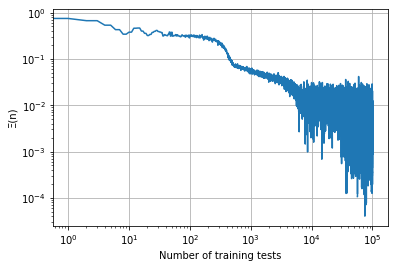

In [22]:
plt.plot(np.sqrt(results))
plt.xlabel('Number of training tests')
plt.ylabel('Ξ(n)')
plt.xscale('log')
plt.yscale('log')
plt.grid()

We can see that the error reaches around $10^{-4}$ which is pretty satisfying.

We now go on to plot our decision rule results on a é dimensionnal grid (zvec,kvec). We first show some 2D results at k fixed or z fixed values. We then plot 3D surfaces of the results for consumption, investment and labour. 

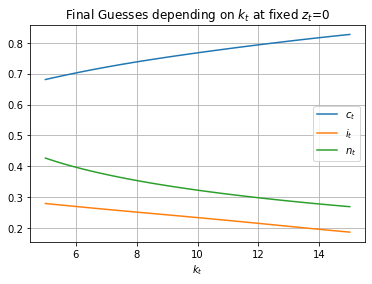

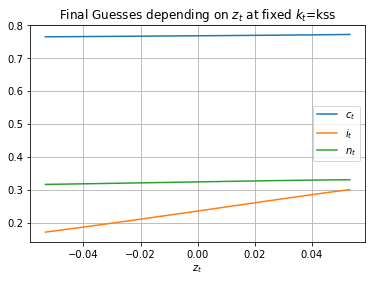

In [23]:
zvec = np.linspace(zmin, zmax, 100)
kvec = np.linspace(kmin, kmax, 100)

cmat = []
imat = []
nmat = []

for z in zvec :
    zvec_const = z*kvec/kvec
    (cvec,ivec) = dr(zvec_const,kvec)
    a = tf.exp(zvec_const)
    a = tf.cast(a, tf.float32)
    b = kvec**α
    b = tf.cast(b, tf.float32)
    nvec = ((cvec+ivec)/(a*b))**(1/(1-α))
    cmat.append(cvec.numpy())
    imat.append(ivec.numpy())
    nmat.append(nvec.numpy())

cmat = np.asarray(cmat)
imat = np.asarray(imat)
nmat = np.asarray(nmat)

plt.figure(1)
#plt.plot(kvec, kvec, linestyle='--', color='black')
plt.plot(kvec,cmat[49],label = '$c_t$')
plt.plot(kvec,imat[49],label = '$i_t$')
plt.plot(kvec,nmat[49],label = '$n_t$')
plt.xlabel("$k_t$")
plt.title("Final Guesses depending on $k_t$ at fixed $z_t$=0")
plt.legend()
plt.grid()

l=[]
m=[]
o=[]
for a in range(len(cmat)):
    l.append(cmat[a][49])
    m.append(imat[a][49])
    o.append(nmat[a][49])

plt.figure(2)
#plt.plot(zvec, zvec, linestyle='--', color='black')
plt.plot(zvec,l,label = '$c_t$')
plt.plot(zvec,m,label = '$i_t$')
plt.plot(zvec,o,label = '$n_t$')
plt.xlabel("$z_t$")
plt.title("Final Guesses depending on $z_t$ at fixed $k_t$=kss")
plt.legend()
plt.grid()

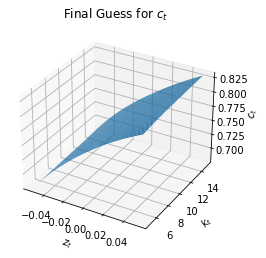

In [24]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
X, Y = np.meshgrid(zvec, kvec)

ax.plot_surface(X, Y, cmat)

ax.set_xlabel('$z_t$')
ax.set_ylabel('$k_t$')
ax.set_zlabel('$c_t$')

plt.title('Final Guess for $c_t$')
plt.show()

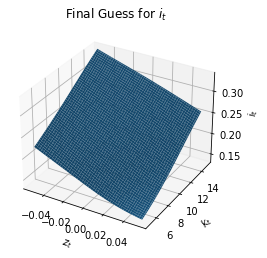

In [25]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
X, Y = np.meshgrid(zvec, kvec)

ax.plot_surface(X, Y, imat)

ax.set_xlabel('$z_t$')
ax.set_ylabel('$k_t$')
ax.set_zlabel('$i_t$')

plt.title('Final Guess for $i_t$')
plt.show()

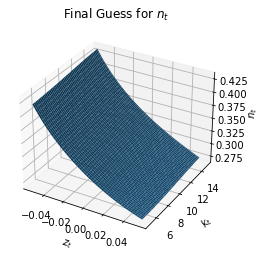

In [26]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
X, Y = np.meshgrid(zvec, kvec)

ax.plot_surface(X, Y, nmat)

ax.set_xlabel('$z_t$')
ax.set_ylabel('$k_t$')
ax.set_zlabel('$n_t$')

plt.title('Final Guess for $n_t$')
plt.show()

For a quick analysis, we can see that all three variables (consumption, investment and labour) increase with capital and with technological progress. Investment increases quicker which would suggest that, first of all quick raises in capital cannot be used straight away and so are invested, second of all technological progress makes it more interesting to invest. Of course, a further investigation in theses results is needed.

# Simulation

# Stochastic simulations

Our goal is to write a function that simulates our model N times for a certain number of time periods T.

In [27]:
def simulate_rbc(model , decision_rule , N , T):           # Pour le moment je n'utilise pas le paramètre model mais l'idée est que c'est ici
                                                           # que l'on obtient les CIs
    β = 0.99
    σ = 5
    η = 1
    δ = 0.025
    α = 0.33
    ρ = 0.8          
    σ_z = 0.016
    kss = 10
    e_z = 0.0
    n = 0.33
    zbar = 0.0
    z = zbar
    rk = 1/β-1+δ
    k = n/(rk/α)**(1/(1-α))
    w = (1-α)*exp(z)*(k/n)**(α)
    y = exp(z)*(k**α)*(n**(1-α))                           # Toutes les conditions initiales 
    i = δ*k                                                # L'objectif sera de na pas écrire toutes ces lignes à la main mais de les extraire
    c = y - i                                              # du modèle dolo.

    epsilon0 = e_z
    z0 = z
    k0 = k
    n0 = n
    i0 = i
    y0 = y
    c0 = c
    rk0 = rk
    w0 = w
    

    simulations = []

    for n in range(N) :

        result = []
        result.append([epsilon0,z0,k0,n0,i0,y0,c0,rk0,w0])          # Initial state

        # Je ne comprend pas pourquoi mon état initial n'est pas le même que celui dans le notebook qui utilise dolo...

        z = np.asarray([z0])
        k = np.asarray([k0])
        epsilon = tf.convert_to_tensor([epsilon0], dtype='float32')       # Because shocks have to be tensors here

        for t in range(T) :
            c,i = decision_rule(z,k)
            a = tf.exp(z)
            a = tf.cast(a, tf.float32)
            b = k**α
            b = tf.cast(b, tf.float32)
            n = ((c+i)/(a*b))**(1/(1-α))
            y = c + i
            rk = α*y/k
            w = (1-α)*y/n
            result.append([epsilon.numpy()[0],z[0],k[0],n.numpy()[0],i.numpy()[0],y.numpy()[0],c.numpy()[0],rk.numpy()[0],w.numpy()[0]])

            epsilon = tf.random.normal(shape=(1,) , stddev=σ_z)              # We define the shock for the next time period 
            z = ρ*z + epsilon                                       # We define k and z for the next time period (knowing the shock epsilon)
            k = (1-δ)*k + i                         
            z = z.numpy()
            k = k.numpy()

        simulations.append(result)
    simulations = np.asarray(simulations)

    return simulations                    # N x T x 9 matrix

In [28]:
sim = simulate_rbc(model,dr,500,40)

    Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
    Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
    Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
    Adding an axes using the same arguments as a previous axes currently reuses the earlier in

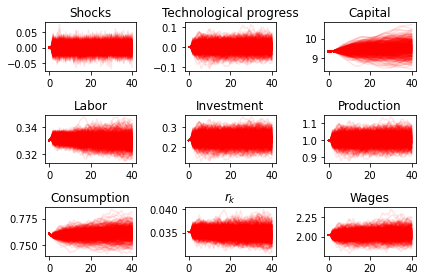

In [29]:
plt.figure()
for i in range(len(sim)):
    list_0=[]
    list_1=[]
    list_2=[]
    list_3=[]
    list_4=[]
    list_5=[]
    list_6=[]
    list_7=[]
    list_8=[]
    for a in sim[i]:
        list_0.append(a[0]) # epsilon
        list_1.append(a[1]) # z
        list_2.append(a[2]) # k
        list_3.append(a[3]) # n
        list_4.append(a[4]) # i
        list_5.append(a[5]) # y
        list_6.append(a[6]) # c
        list_7.append(a[7]) # rk
        list_8.append(a[8]) # w
    plt.subplot(331)
    plt.plot(list_0, color='red', alpha=0.1)
    plt.subplot(332)
    plt.plot(list_1, color='red', alpha=0.1)
    plt.subplot(333)
    plt.plot(list_2, color='red', alpha=0.1)
    plt.subplot(334)
    plt.plot(list_3, color='red', alpha=0.1)
    plt.subplot(335)
    plt.plot(list_4, color='red', alpha=0.1)
    plt.subplot(336)
    plt.plot(list_5, color='red', alpha=0.1)
    plt.subplot(337)
    plt.plot(list_6, color='red', alpha=0.1)
    plt.subplot(338)
    plt.plot(list_7, color='red', alpha=0.1)
    plt.subplot(339)
    plt.plot(list_8, color='red', alpha=0.1)

plt.subplot(331)
plt.title('Shocks')
plt.subplot(332)
plt.title('Technological progress')
plt.subplot(333)
plt.title('Capital')
plt.subplot(334)
plt.title('Labor')
plt.subplot(335)
plt.title('Investment')
plt.subplot(336)
plt.title('Production')
plt.subplot(337)
plt.title('Consumption')
plt.subplot(338)
plt.title('$r_{k}$')
plt.subplot(339)
plt.title('Wages')

plt.tight_layout()

In [30]:
kk = 10
ii = 0.025 * kk
rkrk = 1/0.99 - 1 + 0.025
yy = 1/0.33 * rkrk * kk
cc = yy - ii

print('kk =',kk)
print('ii =',ii)
print('rkrk =',rkrk)
print('yy =',yy)
print('cc =',cc)

kk = 10
ii = 0.25
rkrk = 0.03510101010101017
yy = 1.0636669727578838
cc = 0.8136669727578838


The figures are plausible but there is a sudden change at t = 1 because z1 is 0.8*z0 when I plot the initial state. For this reason I start plotting at t = 1.

In addition, the steady state obtained does not satisfy the steady state equations given in the calibration section.

# Descriptive statistics

A common way to evaluate the success of the RBC model is in its ability to mimic patterns in the descriptive statistics of the real economy. Let us compute some of these descriptive statistics from our sample of stochastic simulations. First we compute growth rates:

In [31]:
dsim = []

for s in range(len(sim)):
    simulation_i = []
    for t in range(len(sim[s])-1):
        l = []
        for variable in range(len(sim[s][t])):
            if sim[s][t][variable] == 0 :
                d = 0.0
            else :
                d = sim[s][t+1][variable]/sim[s][t][variable]
            l.append(d)
        simulation_i.append(l)
    dsim.append(simulation_i)

dsim = np.asarray(dsim)

In [32]:
volat = dsim.std(axis=1)
print(volat.shape)

(500, 9)


In [33]:
table = np.column_stack([
    volat.mean(axis=0),
    volat.mean(axis=0)-1.96*volat.std(axis=0),
    volat.mean(axis=0)+1.96*volat.std(axis=0)  ])
table

array([[ 3.66439835e+01, -3.47451691e+02,  4.20739658e+02],
       [ 2.39294849e+01, -2.41946031e+02,  2.89805001e+02],
       [ 2.83186488e-03,  1.60830238e-03,  4.05542738e-03],
       [ 7.35541453e-03,  5.77079169e-03,  8.94003737e-03],
       [ 8.52075016e-02,  6.41987147e-02,  1.06216288e-01],
       [ 2.10263056e-02,  1.64260758e-02,  2.56265355e-02],
       [ 1.49678598e-03,  1.09453179e-03,  1.89904016e-03],
       [ 2.20669432e-02,  1.72205341e-02,  2.69133523e-02],
       [ 1.39345287e-02,  1.07322891e-02,  1.71367683e-02]])

In [34]:
df = pd.DataFrame(table, index = ['epsilon','z','k','n','i','y','c','rk','w'], columns=['Growth rate std.','Lower 95% bound','Upper 95% bound' ])
pd.set_option('precision', 4)
df

,Growth rate std.,Lower 95% bound,Upper 95% bound
epsilon,36.6440,-347.4517,420.7397
z,23.9295,-241.9460,289.8050
k,0.0028,0.0016,0.0041
n,0.0074,0.0058,0.0089
i,0.0852,0.0642,0.1062
y,0.0210,0.0164,0.0256
c,0.0015,0.0011,0.0019
rk,0.0221,0.0172,0.0269
w,0.0139,0.0107,0.0171


# Error measures